In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skmultiflow.data import HyperplaneGenerator
from skmultiflow.data import ConceptDriftStream, AGRAWALGenerator
from menelaus.data_drift.hdddm import HDDDM

n_samples_per_batch = 4000

# Generate Data Using HyperplaneGenerator
stream = HyperplaneGenerator(random_state=1, n_features=10, n_drift_features=2, mag_change=0.001)

# stream_before_drift = AGRAWALGenerator(random_state=112)
# stream_after_drift = AGRAWALGenerator(random_state=112, classification_function=2)

# # Create the ConceptDriftStream
# stream = ConceptDriftStream(
#     stream=stream_before_drift,
#     drift_stream=stream_after_drift,
#     position=10000,  # Position of the drift
#     width=100,     # Width of the drift transition
#     random_state=1
# )

# # Load your CSV file into a DataFrame
# csv_file_path = 'data/rotatingHyperplane.csv'
# data = pd.read_csv(csv_file_path)

# features = data.iloc[:, :-1]
# target = data.iloc[:, -1]

# # Number of samples per batch and number of batches
# n_batches = len(features) // n_samples_per_batch
# # Create reference and test batches
# data_batches = [features[i * n_samples_per_batch:(i + 1) * n_samples_per_batch] for i in range(n_batches)]

# Generate data for multiple batches
n_batches = 15
data_batches = []

for i in range(n_batches):
    X, y = stream.next_sample(n_samples_per_batch)
    batch_df = pd.DataFrame(X, columns=[f'feature_{j}' for j in range(X.shape[1])])
    data_batches.append(batch_df)

example_data = pd.concat(data_batches, ignore_index=True)

# Setup reference and test batches, using the first batch as reference
reference = data_batches[0]
all_test = data_batches[1:]

# Setup HDDDM
np.random.seed(1)
hdddm = HDDDM(subsets=8)

# Store epsilons per feature for heatmap
batch_indices = range(1, n_batches)
heatmap_data = pd.DataFrame(columns=batch_indices)

# Store drift for test statistic plot
detected_drift = []

# Run HDDDM
hdddm.set_reference(reference)
for i, test_batch in enumerate(all_test):
    hdddm.update(test_batch)
    heatmap_data[i + 1] = hdddm.feature_epsilons
    detected_drift.append(hdddm.drift_state)

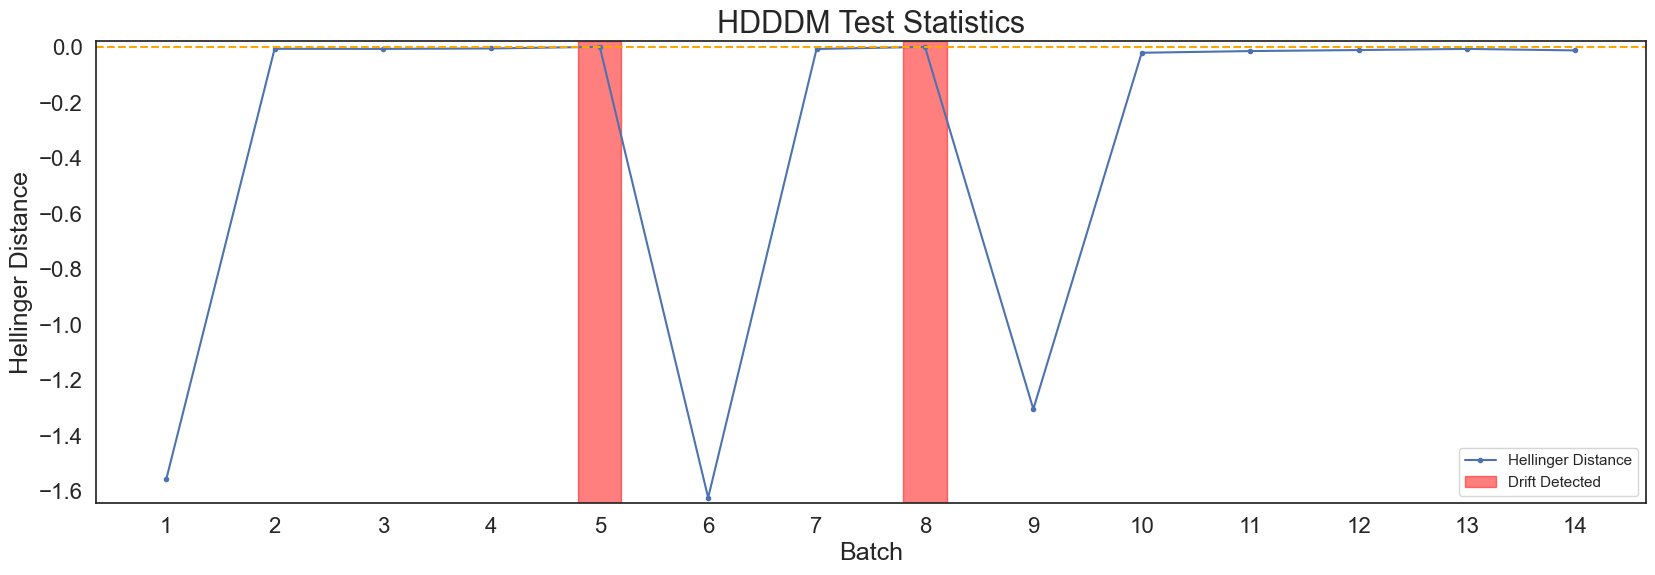

In [16]:
# Plot Line Graph for Hellinger Distance
h_distances = [
    ep - th for ep, th in zip(hdddm.epsilon_values.values(), hdddm.thresholds.values())
]

# Plot Hellinger Distance against Batch Index, along with detected drift
plot_data = pd.DataFrame(
    {"Batch": batch_indices, "Hellinger Distance": h_distances, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(
    "Batch", "Hellinger Distance", data=plot_data, label="Hellinger Distance", marker="."
)
plt.grid(False, axis="x")
plt.xticks(batch_indices, fontsize=16)
plt.yticks(fontsize=16)
plt.title("HDDDM Test Statistics", fontsize=22)
plt.ylabel("Hellinger Distance", fontsize=18)
plt.xlabel("Batch", fontsize=18)
plt.ylim([min(h_distances) - 0.02, max(h_distances) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Batch"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()

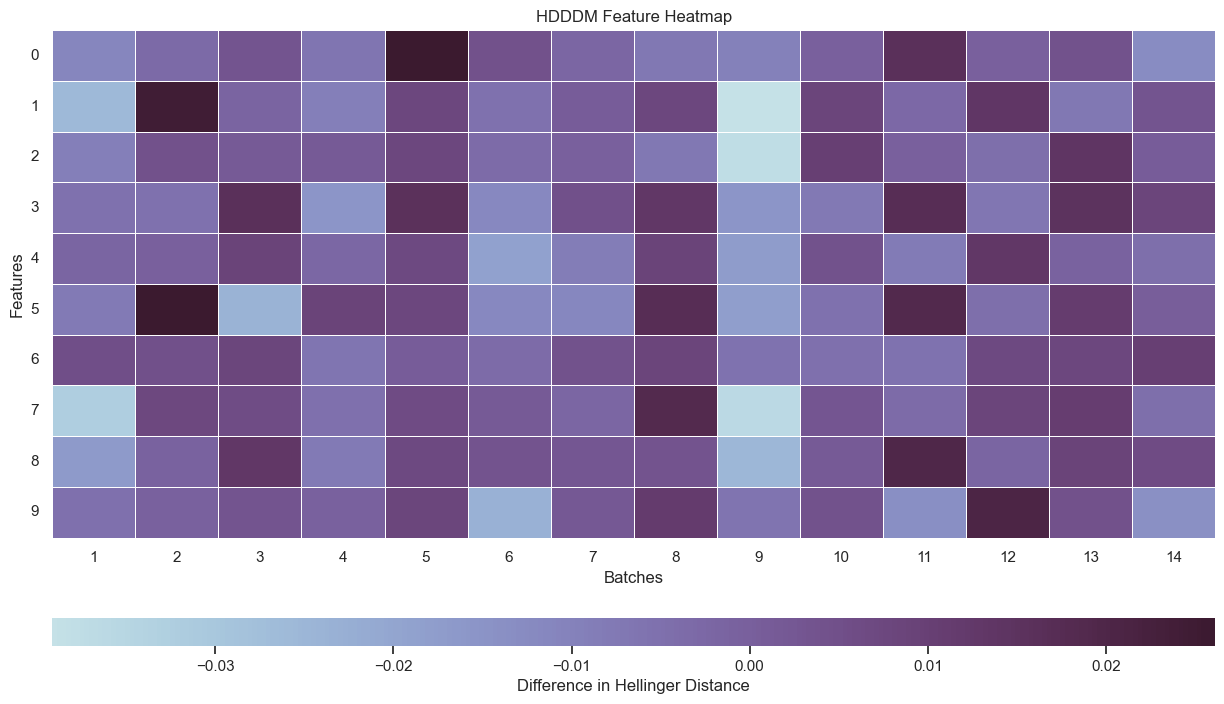

In [17]:
# Plot Heatmap for Feature Epsilons
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (15, 8)})

# Setup plot
grid_kws = {"height_ratios": (0.9, 0.05), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start=0.8, rot=-0.5, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)
ax.set_title('HDDDM Feature Heatmap')
ax.set(xlabel="Batches", ylabel="Features")
ax.collections[0].colorbar.set_label("Difference in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()